In [1]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats, optimize, interpolate
from scipy.optimize import fsolve
from scipy.integrate import odeint
from scipy.integrate import solve_bvp
from scipy.linalg import solve_banded
plt.rcParams.update({'font.size': 18})

In [2]:
#
# Define function cvi_sim which computes resulting pore radius/gas concentration profiles as a function of CVI process parameters
#

def cvi_nonlinear(Tin,Pin, phi0in, rin, ain,plot_line_color,plot_line_label,dt,variable_plotted): # Temperature, pressure, initial pore diameter, aspect ratio, phase ratio, line color, line label, time stepper, variable to plot (between rp and C). 
    
    
    ###
    # CVI CONDITIONS
    ###
    
    phi0 = phi0in     # Pore diameter, m  
    L = rin*phi0      # Length, m
    nz = 28         # Number of grid points, dimensionless
    h = L/(nz+1)      # Distance between grid points, m
    hh = h**2
    dt = dt           # Time stepper, s

    phii = phi0*np.ones(nz)
    phi = phii
    
    Zrange = np.linspace(0,L/2,nz)           # Grid that represents length of specimen
    alpha = ain                            # Ratio between H2 and MTS concentrations at reactor entrance, dimensionless
    P = Pin                                # Pressure, Pa
    T = Tin                                # Temperature, K
    
    
    R = 8.314                              # Ideal gas constant, J/mol K
    
    CMTS0 = (1/(1+alpha))*(P / (R*T))      # MTS concentration at z=0 (BC), mol/m^3
    CH20 = (alpha/(1+alpha))*(P / (R*T))   # H2 concentration at z=0 (1-CMTS0), mol/m^3,  Fedou1993-2 Eqs. 9-10
    CHCl0 = 0                              # HCl concentration at z=0 (1-CMTS0), mol/m^3
    
    k0 = 3.89e9                            # Reaction rate coefficient, m/s
    Ea = 296e3                             # Activation energy, J/mol
    
    CMTS = CMTS0*np.ones(nz)
    CMTS[0] = CMTS0
    CH2 = CH20*np.ones(nz)                     # Gas phase composition at pore entrance, Fedou1993-2 Eqs. 9-10
    CH2[0] = CH20
    CHCl = CHCl0*np.ones(nz)
    CHCl[0] = CHCl0
    
    Ct0_before_penetration = [CMTS, CH2, CHCl]
    
    khet = k0*np.exp(-Ea/(R*T))
    print('khet_fedou=',khet)
    
    
    #### Walker DFT paper
    R = 8.617333262e-5
    T = 1273
    # Ea = 0.918 #mean
    Ea = 0.493 #lower bound
    # Ea = 1.342 #upper bound
    khet = np.exp(-Ea/(R*T))
    print("khet_walker=",khet)
    ####
    
    nu = khet*CMTS         # Kinetic law, Fedou1993-2 Eq. 3
    
    dKMTS = 3.97 #m/sK^(1/2)               # Reduced Knudsen coefficient of MTS, m/s K^1/2
    dKH2 = 34.30 #m/sK^(1/2)               # Reduced Knudsen coefficient of H2, m/s K^1/2,  Fedou1993-2 Table I
    dKHCl = 8.03 #m/sK^(1/2)               # Reduced Knudsen coefficient of HCl, m/s K^1/2
    
    DKMTS=dKMTS*phi*(T**0.5)              # Knudsen diffusion coefficient of MTS, m^2/s 
    DKH2=dKH2*phi*(T**0.5)                # Knudsen diffusion coefficient of H2, m^2/s,  Fedou1993-2 Eq. 2
    DKHCl=dKHCl*phi*(T**0.5)              # Knudsen diffusion coefficient of HCl, m^2/s 
    
    # MSiC = 0.04011                       # Molar mass of SiC, kg/mol
    MMTS = 0.149                             # Molar mass of MTS, kg/mol
    MH2 = 2e-3                             # Molar mass of H2, kg/mol,  Fedou1993-2 Table I
    MHCl = 3.65e-2                         # Molar mass of HCl, kg/mol
    
    # rhoSiC = 3217                        # Density of SiC, kg/m^3
    # rhoMTS = 1270
    # rhoH2 = 0.08375
    # rhoHCl = 1048
    
    VSiC = 12.5e-6                         # Specific volume of SiC, m^3/mol,  Fedou1993-2 Section 2.2
    VMTS = 122.7e-6                          # Specific volume of MTS, m^3/mol
    VH2  = 14.3e-6                            # Specific volume of H2, m^3/mol,  Fedou1993-2 Table III
    VHCl = 25.3e-6                          # Specific volume of HCl, m^3/mol
    
    # VMTS = 122.7                          # Specific volume of MTS, cm^3/mol
    # VH2  = 14.3                            # Specific volume of H2, cm^3/mol,  Fedou1993-2 Table III
    # VHCl = 25.3                          # Specific volume of HCl, cm^3/mol
    
    sMTS = -1
    sH2 = 0                               # Stoichiometric coefficients of the chemical elements, Fedou1993-1 Eq. 1 and Fedou1993-2 Eq. 1
    sHCl = 3
    sSiC = 1
    deltas = sMTS + sH2 + sHCl + sSiC             # Sum of coefficients, Fedou1993-1 Eq. 11
    s = [sMTS, sH2, sHCl, sSiC]

    Dij_MTSH2 = 1.360e-3*((T**(3/2))/(P*(VH2**(1/3)+VMTS**(1/3))**2))*(1/MH2 + 1/MMTS)**0.5
    Dij_MTSHCl = 1.360e-3*((T**(3/2))/(P*(VHCl**(1/3)+VMTS**(1/3))**2))*(1/MHCl + 1/MMTS)**0.5   # Gilliland formula, Fedou1993-1 Appendix 1 Eq A4
    
    epsik = 59.7
    sigi = 0.2827e-9
    epsjk = 344.7
    sigj = 0.3339e-9
    sigij = (sigi+sigj)/2
    kepsij = (epsik * epsjk)**(-0.5)
    Tstar = kepsij*T
    Tstar = np.rint(Tstar)
    if Tstar ==7:
        omegaD = 0.79643333
    if Tstar == 8: 
        omegaD = 0.78003333                # Hirschfelder formula, Fedou1993-1 Appendix 1 Eqs. A1-A3; calculation of 
    if Tstar == 9:
        omegaD = 0.76611111
    if Tstar == 10:
        omegaD = 0.75401111
    V = 2.78125e4

    Dij_H2HCl = 5.876e-24  *((T**1.5)/(P*(sigij**2)*V*omegaD))*((1/MH2 + 1/MHCl)**0.5)
    Dij_H2HCl = 1.360e-3*((T**(3/2))/(P*(VHCl**(1/3)+VH2**(1/3))**2))*(1/MHCl + 1/MH2)**0.5 
    # print("dfomega=",Dij_H2HCl, "dfvhcl=",Dij_H2HCl_v2)
    
    N = deltas*nu
    
    xMTS  = CMTS/(CMTS+CH2+CHCl)
    xH2 = CH2/(CMTS+CH2+CHCl)                                     # Molar fractions, Fedou1993-1 Eq. 13                                    
    xHCl = CHCl/(CMTS+CH2+CHCl)
    
    dxMTSdz = dxH2dz = dxHCldz = np.zeros(nz)
    
    # DFMTS = ((1/(1-xMTS[0]))*(xHCl[0]/Dij_MTSHCl + xH2[0]/Dij_MTSH2))**(-1)
    # DFH2 = ((1/(1-xH2[0]))*(xHCl[0]/Dij_H2HCl + xMTS[0]/Dij_MTSH2))**(-1)      # Fick diffusion coefficients, Fedou1993-1 Eq. 16
    # DFHCl = ((1/(1-xHCl[0]))*(xH2[0]/Dij_H2HCl + xMTS[0]/Dij_MTSHCl))**(-1)
    
    DFMTS = ((1/(1-xMTS))*(xHCl/Dij_MTSHCl + xH2/Dij_MTSH2))**(-1)
    DFH2 = ((1/(1-xH2))*(xHCl/Dij_H2HCl + xMTS/Dij_MTSH2))**(-1)      # Fick diffusion coefficients, Fedou1993-1 Eq. 16
    DFHCl = ((1/(1-xHCl))*(xH2/Dij_H2HCl + xMTS/Dij_MTSHCl))**(-1)

    DMTS = (1/DFMTS + 1/DKMTS)**(-1)          
    DH2 = (1/DFH2 + 1/DKH2)**(-1)          # Overall diffusion coefficient, Fedou1993-1 Eq. 15
    DHCl = (1/DFHCl + 1/DKHCl)**(-1) 
    
    ###
    # INITIALIZE SOLUTION VECTORS
    ###
    
    Csol = []
    Dsol = []
    for k in range(nz):
        Dsol = np.append(Dsol,DMTS[k])
        Dsol = np.append(Dsol,DH2[k])  # D matrix
        Dsol = np.append(Dsol,DHCl[k])
        Csol = np.append(Csol,CMTS[k])
        Csol = np.append(Csol,CH2[k])  # C matrix
        Csol = np.append(Csol,CHCl[k])
    C0sol = Csol

    print('----------------------------------T=',T,'P=',P, 'CMTS0=',CMTS0,'CH20=',CH20,'CHCl0=',CHCl0)

    
    CMTSt = []                             
    CH2t = []                              # Array containing gas concentration profiles of MTS, H2, HCl
    CHClt = []
    
    phit = []
    rpt = []
    
    percent_closed = 0                     # Dimensionless rating of pore size relative to initial pore size
    counter =0                             # Time counter
    
    
    ###
    # NONLINEAR ITERATIVE SOLVER
    ###
    
    while any(phi<phi0/100) is not True:
        
        # Assemble D, C matrices so that (gas,gridpt)=(i,j) = Cm[3j+i]. Gases\in [0,2] = [MTS, H2, HCl]. Gridpts\in [0,n+1]
        # So C_{1,j} = C_{2,5} = C[3*5 + 2 = C[17].
        Csol = []
        Dsol = []
        
        for k in range(nz):
            Dsol = np.append(Dsol,DMTS[k])
            Dsol = np.append(Dsol,DH2[k])  # D matrix
            Dsol = np.append(Dsol,DHCl[k])
            Csol = np.append(Csol,CMTS[k])
            Csol = np.append(Csol,CH2[k])  # C matrix
            Csol = np.append(Csol,CHCl[k])
        # if counter==0:
        #     print('C=',Csol.size,'D=',Dsol.size)
        #     print(Csol,Dsol)
        
        def F(C, *data_args):
            D, h, hh, N, s, nu, phi = data_args
            exps = []
            n = nz-2
            for j in range(1,n+1): #1\leq j\leq n. #nz=7--> j=1,2,3,4,5     
                # print(C.size)
                # print(j)
                if j==1:
                    xi_jp1 = C[3]/(C[3]+C[4]+C[5])
                    xi_jm1 = CMTS0/(CMTS0 +CH20 + CHCl0)
                    exps = np.append(exps, (CMTS0 - 2*C[0] + C[3])/hh - (xi_jp1*N[2]-xi_jm1*N[0])/(2*D[0]*h) + (4*s[0]*nu[0])/(D[0]*phi[0]))
                    # print("exps1=",exps.size)
                    
                    xi_jp1 = C[4]/(C[4]+C[5]+C[3])
                    xi_jm1 = CH20/(CMTS0 +CH20 + CHCl0)
                    exps = np.append(exps, (CH20 - 2*C[1] + C[4])/hh - ((xi_jp1*N[2]-xi_jm1*N[0])/(2*D[1]*h)) + (4*s[1]*nu[0])/(D[1]*phi[0]))
                    # print("exps2=",exps.size)
                    
                    xi_jp1 = C[5]/(C[5]+C[4]+C[3])
                    xi_jm1 = CHCl0/(CMTS0 +CH20 + CHCl0)
                    exps = np.append(exps, (CHCl0 - 2*C[2] + C[5])/hh - ((xi_jp1*N[2]-xi_jm1*N[0])/(2*D[2]*h)) + (4*s[2]*nu[0])/(D[2]*phi[0]))
                    # print("exps3=",exps.size)
                    
                if not j==1 and not j==n: #j=2,3,4
                    for i in range(3): #i=0,1,2
                        if i==0: #defining molar fractions for each gas i. MTS
                            xi_jp1 = C[3*j]/(C[3*j]+C[3*j+1]+C[3*j+2])
                            xi_jm1 = C[3*(j-2)]/(C[3*(j-2)]+C[3*(j-2)+1]+C[3*(j-2)+2])
                        if i==1: #H2
                            xi_jp1 = C[3*j+1]/(C[3*j+1]+C[3*j+2]+C[3*j])
                            xi_jm1 = C[3*(j-2)+1]/(C[3*(j-2)+1]+C[3*(j-2)+2]+C[3*(j-2)])
                        if i==2: #HCl
                            xi_jp1 = C[3*j+2]/(C[3*j+2]+C[3*j+1]+C[3*j])
                            xi_jm1 = C[3*(j-2)+2]/(C[3*(j-2)+2]+C[3*(j-2)+1]+C[3*(j-2)])

                        expij = (C[3*(j-2)+i] - 2*C[3*(j-1)+i] + C[3*j+i])/hh - (xi_jp1*N[j+1]-xi_jm1*N[j-1])/(2*D[3*(j-1)+i]*h) + (4*s[i]*nu[j-1])/(D[3*(j-1)+i]*phi[j-1])
                        exps = np.append(exps, expij)
                        # print("exps4=",exps.size)
                        
                if j==n: #j=5,
                    for i in range(3):
                        if i==0: #defining molar fractions for each gas i. MTS
                            xi_jp1 = C[3*(n-1)]/(C[3*(n-1)]+C[3*(n-1)+1]+C[3*(n-1)+2])
                            xi_jm1 = C[3*(n-2)]/(C[3*(n-2)]+C[3*(n-2)+1]+C[3*(n-2)+2])
                        if i==1: #H2
                            xi_jp1 = C[3*(n-1)+1]/(C[3*(n-1)+1]+C[3*(n-1)+2]+C[3*(n-1)])
                            xi_jm1 = C[3*(n-2)+1]/(C[3*(n-2)+1]+C[3*(n-2)+2]+C[3*(n-2)])
                        if i==2: #HCl
                            xi_jp1 = C[3*(n-1)+2]/(C[3*(n-1)+2]+C[3*(n-1)+1]+C[3*(n-1)])
                            xi_jm1 = C[3*(n-2)+2]/(C[3*(n-2)+2]+C[3*(n-2)+1]+C[3*(n-2)])

                        expij = (C[3*(n-2)+i] - C[3*(n-1)+i])/hh - (xi_jp1*N[n+1]-xi_jm1*N[n-1])/(2*D[3*(n-1)+i]*h) + (4*s[i]*nu[n-1])/(D[3*(n-1)+i]*phi[n-1])
                        exps = np.append(exps, expij)
            return exps
        
        data_args = (Dsol[3:-3], h, hh, N, s, nu[1:-1], phi[1:-1])
        Csol = fsolve(F, C0sol[3:-3], args=data_args)
        Csol = np.insert(Csol, 0, CHCl0)
        Csol = np.insert(Csol, 0, CH20)           # left boundary condition
        Csol = np.insert(Csol, 0, CMTS0)
        for _ in range(3):
            Csol = np.append(Csol, Csol[-3])      # right boundary condition
            
        CMTS = Csol[0::3]
        CH2 = Csol[1::3]
        CHCl = Csol[2::3]
    
        # khet = k0*np.exp(-Ea/(R*T))
        # khet =
    
        nu = khet*CMTS                            # Kinetic law, Fedou1993-2 Eq. 3
        N = deltas*nu 
        phi = phi - (2*dt*nu*VSiC)                # Update pore diameter

        DFMTS = ((1/(1-xMTS))*(xHCl/Dij_MTSHCl + xH2/Dij_MTSH2))**(-1)
        DFH2 = ((1/(1-xH2))*(xHCl/Dij_H2HCl + xMTS/Dij_MTSH2))**(-1)     # Update Fick diffusion coefficients, Fedou1993-1 Eq. 16
        DFHCl = ((1/(1-xHCl))*(xH2/Dij_H2HCl + xMTS/Dij_MTSHCl))**(-1)
        
        DKMTS = dKMTS*phi*(T**0.5)
        DKH2 = dKH2*phi*(T**0.5)                                      # Update Knudsen diffusion coefficients, Fedou1993-2 Eq. 2
        DKHCl = dKHCl*phi*(T**0.5)

        DMTS = (1/DFMTS + 1/DKMTS)**(-1)          
        DH2 = (1/DFH2 + 1/DKH2)**(-1)                                    # Update overall diffusion coefficient, Fedou1993-1 Eq. 15
        DHCl = (1/DFHCl + 1/DKHCl)**(-1)              

        
        counter+=1
        rpt.append(phi[0]/2)
        if counter % 10 == 0:
            # print(rpt)
            CMTSt.append(CMTS)
            CH2t.append(CH2) # Collect pore diameter/gas concentration profiles at current time step
            CHClt.append(CHCl)
            # print("nu=",nu[0:3],"CMTS=",CMTS[0:3])
            phit.append(phi)
            percent_closed = 100*(1 -(phi[0]-phi0/100)/phi0)
            print('counter=',counter,': at t =',round(counter*dt*0.000277778,2),'hours, pore is', round(percent_closed,2),'% closed')
    print(counter) 
    t_f_hrs = counter*dt*0.000277778
    t_f_secs = counter*dt
    d = (phii-phi)/2
    # print('phi=',phi,'CMTS=', CMTS)
    
    counter_t = np.arange(0,counter,dt)
    # print('counter_t=',counter_t)
    # print(np.shape(counter_t), np.shape(rpt))
    
    
    ###
    # MOOSE DAMAGE INPUT
    ###
    
    rp = phi/2
    porosity = 0.30
    RpRVE = np.sqrt(1/porosity)*(phi0/2)

    # print('rp=',rp)
    xi = (rp**2)/(RpRVE**2)
    
    mesh_height = 7.5e-5
    num_elements = 28 #ideally =nz
    element_positions = np.linspace(0, mesh_height, num_elements)  
    
    moose_input_i = ''
    par_input = ''
    for q in range(num_elements-1):
        moose_input = str(moose_input_i)+'if(y>='+str(element_positions[num_elements-2-q])+', '+str(xi[q])+', '
        moose_input_i = moose_input
        par_input = str(par_input)+')'
    moose_input = str(moose_input_i)+' 0'+str(par_input)
    
    print('xi=',xi)
    print('moose input for damage is: ',moose_input)
    
    
    return [Zrange, CMTS,CH2,CHCl, phi, d, L, str(plot_line_label), rp, xi, khet, t_f_hrs, t_f_secs, rpt, counter_t]

In [3]:
#
# Call the function cvi_sim
#

# Inputs: Temperature (K), pressure (Pa), pore diameter (m), aspect ratio, gas ratio,      ...
#         plot line color, plot line label, dt, variable to be plotted between "phi" or "C".

In [4]:
a = cvi_nonlinear(1273,20000,100e-6, 100, 10, '','',1,'')
# b = cvi_nonlinear(1073,20000,100e-6, 100, 10, '','',1000,'')
# c = cvi_nonlinear(1303,20000,100e-6, 100, 10, '','',1,'')

khet_fedou= 0.0027786172881957174
khet_walker= 0.011174398605138988
----------------------------------T= 1273 P= 20000 CMTS0= 0.1717903983288505 CH20= 1.717903983288505 CHCl0= 0
counter= 10 : at t = 0.0 hours, pore is 1.48 % closed
counter= 20 : at t = 0.01 hours, pore is 1.96 % closed
counter= 30 : at t = 0.01 hours, pore is 2.44 % closed
counter= 40 : at t = 0.01 hours, pore is 2.92 % closed


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


counter= 50 : at t = 0.01 hours, pore is 3.4 % closed
counter= 60 : at t = 0.02 hours, pore is 3.88 % closed


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


counter= 70 : at t = 0.02 hours, pore is 4.36 % closed
counter= 80 : at t = 0.02 hours, pore is 4.84 % closed
counter= 90 : at t = 0.03 hours, pore is 5.32 % closed
counter= 100 : at t = 0.03 hours, pore is 5.8 % closed
counter= 110 : at t = 0.03 hours, pore is 6.28 % closed
counter= 120 : at t = 0.03 hours, pore is 6.76 % closed
counter= 130 : at t = 0.04 hours, pore is 7.24 % closed
counter= 140 : at t = 0.04 hours, pore is 7.72 % closed
counter= 150 : at t = 0.04 hours, pore is 8.2 % closed
counter= 160 : at t = 0.04 hours, pore is 8.68 % closed
counter= 170 : at t = 0.05 hours, pore is 9.16 % closed
counter= 180 : at t = 0.05 hours, pore is 9.64 % closed
counter= 190 : at t = 0.05 hours, pore is 10.12 % closed
counter= 200 : at t = 0.06 hours, pore is 10.6 % closed
counter= 210 : at t = 0.06 hours, pore is 11.08 % closed
counter= 220 : at t = 0.06 hours, pore is 11.56 % closed
counter= 230 : at t = 0.06 hours, pore is 12.04 % closed
counter= 240 : at t = 0.07 hours, pore is 12.52 %

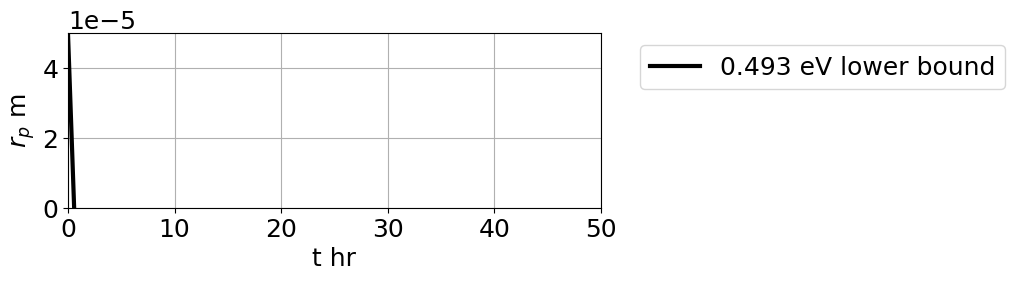

In [30]:
fig, ax = plt.subplots(figsize = (10,2.7), layout='constrained')
# a[-1]=a[-1]/3600
# ax.plot(np.linspace(0,5,5),np.ones(5)*0.3,color='black',linestyle='--',label='Initial')
# ax.plot(c[0],c[5],label='1303K',color='blue',linewidth=3)
ax.plot(np.linspace(0,a[-1][-1],len(a[-2])),a[-2],label='0.493 eV lower bound',color='black',linewidth=3)
# ax.plot(b[0],b[5],label='1073K',color='red',linewidth=3)
plt.ylim([0,5e-5])
plt.xlim([0,50])
# plt.yticks(np.arange(0, 60, step=10))
ax.set_xlabel('t hr')
ax.set_ylabel(r'$r_p$ m')
# ax.set_title(r'$\xi_0 = 0.30$')
ax.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.savefig('walker_rp_t_0493.svg', dpi=220,bbox_inches='tight')
plt.savefig('walker_rp_t_0493.pdf', dpi=220,bbox_inches='tight')

In [34]:
# print(np.linspace(0,a[-1][-1],len(a[-2])))
# print(len(a[-2]))
print(a[-2])

[4.9976004320156724e-05, 4.9952008640313446e-05, 4.992801296047017e-05, 4.990401728062689e-05, 4.988002160078361e-05, 4.985602592094033e-05, 4.9832030241097055e-05, 4.9808034561253776e-05, 4.97840388814105e-05, 4.976004320156722e-05, 4.973604752172394e-05, 4.971205184188066e-05, 4.9688056162037385e-05, 4.966406048219411e-05, 4.964006480235083e-05, 4.961606912250755e-05, 4.959207344266427e-05, 4.9568077762820994e-05, 4.9544082082977715e-05, 4.952008640313444e-05, 4.949609072329116e-05, 4.947209504344788e-05, 4.94480993636046e-05, 4.9424103683761324e-05, 4.9400108003918046e-05, 4.937611232407477e-05, 4.935211664423149e-05, 4.932812096438821e-05, 4.930412528454493e-05, 4.9280129604701655e-05, 4.9256133924858376e-05, 4.92321382450151e-05, 4.920814256517182e-05, 4.918414688532854e-05, 4.916015120548526e-05, 4.9136155525641985e-05, 4.911215984579871e-05, 4.908816416595543e-05, 4.906416848611215e-05, 4.904017280626887e-05, 4.9016177126425594e-05, 4.8992181446582315e-05, 4.896818576673904e-05,

In [6]:
# fig, ax = plt.subplots(figsize = (7,2.7), layout='constrained')

# ax.plot(a[-1],a[-2],label='K='+str(round(a[-5],6)))
# # ax.plot(b[-1],b[-2],label='9.85')

# ax.set_xlabel('t s')
# ax.set_ylabel('$r_p$ $\mu$m')
# # plt.xlim([0,1000])
# # plt.xticks(np.arange(0, 6, step=1))
# # plt.ylim([0,50])
# # plt.yticks(np.arange(0, (50 + 50/5), step=50/5))
# plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
# ax.grid(True)

# plt.savefig('dP.svg', dpi=220,bbox_inches='tight')

In [7]:
# c = cvi_nonlinear(1223,2000,34e-6, 10e-3/34e-6, 5, "blue",r"$1273$K, $dt = 1$s",100,"phi")
# b = cvi_nonlinear(1223,10000,34e-6, 10e-3/34e-6, 5, "blue",r"$1273$K, $dt = 1$s",10,"phi")
# a = cvi_nonlinear(1223,20000,34e-6, 10e-3/34e-6, 5, "blue",r"$1273$K, $dt = 1$s",10,"phi")

In [8]:
# #P comparison

# fig, ax = plt.subplots(figsize = (7,2.7), layout='constrained')

# arr_10kpa_x = np.array([0.89,1.48,1.89,2.89,3.08,5.68])
# arr_10kpa_y = np.array([0.92,6.98,9.98,13.01,13.49,15.76])

# arr_2kpa_x = np.array([0.41, 2.38, 3.28, 4.39, 4.99])
# arr_2kpa_y = np.array([0.76, 14.68, 16, 16.7,16.92])

# arr_10kpa_x = arr_10kpa_x - arr_10kpa_x[0]
# arr_2kpa_x = arr_2kpa_x - arr_2kpa_x[0]
# arr_10kpa_y = 17 - (arr_10kpa_y - arr_10kpa_y[0])
# arr_2kpa_y = 17 - (arr_2kpa_y - arr_2kpa_y[0])

# # ax.plot(b[0]*1000,a[5]*1e6,label=r'20kPa',color='blue')
# ax.plot(b[0]*1000,b[5]*1e6,label=r'10kPa, calc',color='green')
# ax.scatter(arr_10kpa_x, arr_10kpa_y,color='green',label='10kPa, exp',marker=matplotlib.markers.CARETUPBASE)
# ax.plot(c[0]*1000,c[5]*1e6,label=r'2kPa, calc',color='red')
# ax.scatter(arr_2kpa_x, arr_2kpa_y,color='red',label='2kPa, exp',marker=matplotlib.markers.CARETDOWNBASE)

# ax.set_xlabel('z mm')
# ax.set_ylabel('$d$ $\mu$m')
# plt.xlim([0,5])
# plt.xticks(np.arange(0, 6, step=1))
# plt.ylim([0,17])
# plt.yticks(np.arange(0, (17 + 17/5), step=17/5))
# plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
# ax.grid(True)

# plt.savefig('dP.svg', dpi=220,bbox_inches='tight')




In [9]:
# llp = cvi_nonlinear(1173,5000,100e-6, 100, 10, "blue",r"$1273$K, $dt = 1$s",1000,"phi")

In [10]:
# lp = cvi_nonlinear(1173,10000,100e-6, 100, 10, "blue",r"$1273$K, $dt = 1$s",1000,"phi")

In [11]:
# n = cvi_nonlinear(1173,20000,100e-6, 100, 10, "blue",r"$1273$K, $dt = 1$s",500,"phi")

In [12]:
# hp = cvi_nonlinear(1173,35000,100e-6, 100, 10, "blue",r"$1273$K, $dt = 1$s",100,"phi")

In [13]:
# hhp = cvi_nonlinear(1173,50000,100e-6, 100, 10, "blue",r"$1273$K, $dt = 1$s",200,"phi")

In [14]:
# b = cvi_nonlinear(1123,20000,100e-6, 100, 10, "blue",r"$1273$K, $dt = 1$s",1000,"phi")

In [15]:
# c = cvi_nonlinear(1173,20000,100e-6, 100, 10, "blue",r"$1273$K, $dt = 1$s",500,"phi")

In [16]:
# d = cvi_nonlinear(1223,20000,100e-6, 100, 10, "blue",r"$1273$K, $dt = 1$s",100,"phi")

In [17]:
# e = cvi_nonlinear(1273,20000,100e-6, 100, 10, "blue",r"$1273$K, $dt = 1$s",50,"phi")

In [18]:
# f = cvi_nonlinear(1283,20000,100e-6, 100, 10, "blue",r"$1273$K, $dt = 1$s",40,"phi")

In [19]:
# g= cvi_nonlinear(1293,20000,100e-6, 100, 10, "blue",r"$1273$K, $dt = 1$s",30,"phi")

In [20]:
# h= cvi_nonlinear(1303,20000,100e-6, 100, 10, "blue",r"$1273$K, $dt = 1$s",25,"phi")

In [21]:
# fig, ax = plt.subplots(figsize = (7,3), layout='constrained')

# tp_t = np.array([1073, 1173, 1173, 1173, 1173, 1173, 1273])
# tp_p = np.array([20, 5, 10, 20, 35, 50, 20])
# tp_tf = np.array([358.33, 92.22, 46.11, str(23.06)+' hrs', 13.67, 9.22, 2.31])

# ax.scatter(tp_t, tp_p,color='red')
# for i, txt in enumerate(tp_tf):
#     ax.annotate(txt, (tp_t[i],tp_p[i]),fontsize=13)

# ax.set_xlabel('$T$ K')
# ax.set_ylabel('$P$ kPa')
# plt.xlim([1073-27,1300])
# plt.xticks(np.arange(1073, 1373, step=100))
# plt.ylim([0,60])
# plt.yticks(np.arange(0, 60, step=10))
# plt.title(r'$t_f$ vs. {$T,P$}')
# # plt.legend(bbox_to_anchor=(1.05, 1.1), loc="upper left")
# ax.grid(True)

# plt.savefig('pt.svg', dpi=220,bbox_inches='tight')
    

In [22]:
# i= cvi_nonlinear(1313,20000,100e-6, 100, 10, "blue",r"$1273$K, $dt = 1$s",5,"phi")

In [23]:
# #T comparison

# c = cvi_nonlinear(1073,20000,100e-6, 100, 10, "blue",r"$1273$K, $dt = 1$s",10000,"phi")
# b = cvi_nonlinear(1173,20000,100e-6, 100, 10, "blue",r"$1273$K, $dt = 1$s",1000,"phi")
# a = cvi_nonlinear(1273,20000,100e-6, 100, 10, "blue",r"$1273$K, $dt = 1$s",1,"phi")

In [24]:
# fig, ax = plt.subplots(figsize = (7,2.7), layout='constrained')

# arr_10kpa_x = np.array([1.01, 2.02, 3.02, 4.01, 5.02, 6.01])
# arr_10kpa_y = np.array([2.62, 3.38, 3.88, 4.05, 4.22, 4.31])

# arr_11kpa_x = np.array([1.01, 2.02, 3.02, 4.01, 5.02, 6.01])
# arr_11kpa_y = np.array([2.62, 7.43, 11.06, 13.26, 14.19, 14.70])

# arr_12kpa_x = np.array([1.01, 2.02, 3.02, 4.01, 5.02, 6.01])
# arr_12kpa_y = np.array([2.62, 18.66, 28.88, 33.78, 36.57, 37.33])

# arr_10kpa_x = arr_10kpa_x - arr_10kpa_x[0]
# arr_11kpa_x = arr_11kpa_x - arr_11kpa_x[0]
# arr_12kpa_x = arr_12kpa_x - arr_12kpa_x[0]

# arr_10kpa_y = 50 - (arr_10kpa_y - arr_10kpa_y[0])
# arr_11kpa_y = 50 - (arr_11kpa_y - arr_11kpa_y[0])
# arr_12kpa_y = 50 - (arr_12kpa_y - arr_12kpa_y[0])
# ax.plot(b[0]*1000,c[5]*1e6,label=r'1073K',color='blue')
# ax.scatter(arr_10kpa_x, arr_10kpa_y,color='blue',label='1073K, exp',marker=matplotlib.markers.CARETDOWNBASE)
# ax.plot(b[0]*1000,b[5]*1e6,label=r'1173K',color='green')
# ax.scatter(arr_11kpa_x, arr_11kpa_y,color='green',label='1173K, exp',marker='X')
# ax.plot(b[0]*1000,a[5]*1e6,label=r'1273K',color='red')
# ax.scatter(arr_12kpa_x, arr_12kpa_y,color='red',label='1273K, exp',marker=matplotlib.markers.CARETUPBASE)




# ax.set_xlabel('z mm')
# ax.set_ylabel('$d$ $\mu$m')
# plt.xlim([0,5])
# plt.xticks(np.arange(0, 6, step=1))
# plt.ylim([0,50])
# plt.yticks(np.arange(0, 60, step=10))
# plt.legend(bbox_to_anchor=(1.05, 1.1), loc="upper left")
# ax.grid(True)

# plt.savefig('dT.svg', dpi=220,bbox_inches='tight')

In [25]:
# #alpha comparison

# c = cvi_nonlinear(1273,20000,100e-6, 100, 100, "blue",r"$1273$K, $dt = 1$s",1000,"phi")
# b = cvi_nonlinear(1273,20000,100e-6, 100, 10, "blue",r"$1273$K, $dt = 1$s",100,"phi")
# a = cvi_nonlinear(1273,20000,100e-6, 100, 1, "blue",r"$1273$K, $dt = 1$s",10,"phi")

# fig, ax = plt.subplots(figsize = (7,2.7), layout='constrained')

# ax.plot(a[0]*1000,a[1],label=r'MTS, $\alpha=1$',color='red')
# ax.plot(a[0]*1000,a[2],label=r'H2, $\alpha=1$',color='blue')
# ax.plot(a[0]*1000,a[3],label=r'HCl, $\alpha=1$',color='green')
# ax.set_xlabel('z mm')
# ax.set_ylabel('$C_i$ mol/m$^3$')
# plt.xlim([0,5])
# plt.xticks(np.arange(0, 6, step=1))
# plt.title(r'$\alpha=1$')
# plt.ylim([0,1.5])
# plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
# ax.grid(True)

# plt.savefig('alpha1.svg', dpi=220,bbox_inches='tight')


# fig, ax = plt.subplots(figsize = (7,2.7), layout='constrained')

# ax.plot(b[0]*1000,b[1],label=r'MTS',color='red')
# ax.plot(b[0]*1000,b[2],label=r'H2',color='blue')
# ax.plot(b[0]*1000,b[3],label=r'HCl',color='green')
# ax.set_xlabel('z mm')
# ax.set_ylabel('$C_i$ mol/m$^3$')
# plt.xlim([0,5])
# plt.xticks(np.arange(0, 6, step=1))
# plt.title(r'$\alpha=10$')
# plt.ylim([-0.2,2])
# plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
# ax.grid(True)

# plt.savefig('alpha10.svg', dpi=220,bbox_inches='tight')

# fig, ax = plt.subplots(figsize = (7,2.7), layout='constrained')

# ax.plot(c[0]*1000,c[1],label=r'MTS',color='red')
# ax.plot(c[0]*1000,c[2],label=r'H2',color='blue')
# ax.plot(c[0]*1000,c[3],label=r'HCl',color='green')
# ax.set_xlabel('z mm')
# ax.set_ylabel('$C_i$ mol/m$^3$')
# plt.xlim([0,5])
# plt.xticks(np.arange(0, 6, step=1))
# plt.ylim([-0.2,2])
# plt.title(r'$\alpha=100$')
# plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
# ax.grid(True)

# plt.savefig('alpha100.svg', dpi=220,bbox_inches='tight')